# MultiSensor Data Collection - Data visualization
Data viewer for information collected through the MultiSensor Data Collection Application, which is a mobile app that gathers data from various mobile sensors such as the accelerometer, gyroscope, magnetometer, and gravity. Data related to geolocation (GPS), audio, and video (camera) are also collected. All this information enables us to create a dataset related to **Human Activity Recognition** and **Urban Informatics**.

The goal of this notebook is to load a few sample datasets and present interesting visualizations.

## 1. Configuration
This section provides instructions for configuring the data path, defining file columns, loading essential libraries, and setting up Google Drive if required.

In [ ]:
# Where are the files located?
PATH_DATA = 'MyDrive/science/creativision/projects/uic - vision and sensors/data/v4'

# Are they stored in Google Drive?
USE_GOOGLE_DRIVE = True

import os

if USE_GOOGLE_DRIVE:
  from google.colab import drive

  PATH_GOOGLE_DRIVE = '/gdrive'
  drive.mount(PATH_GOOGLE_DRIVE)

  PATH_DATA = os.path.join('/gdrive', PATH_DATA)

# Ensure that the files follows this datetime format
DATETIME_UTC_FORMAT ="%Y-%m-%dT%H:%M:%S.%fZ"

# Ensure that the files have the following columns
GPS_FILE_FIELDNAMES = [
    'datetime_utc',
    'gps_interval',
    'accuracy',
    'latitude',
    'longitude',
]

ONE_AXIS_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'accuracy',
]

THREE_AXES_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'axis_y',
    'axis_z',
    'accuracy',
]

THREE_AXES_UNCALIBRATED_SENSORS_FILE_FIELDNAMES = [
    'timestamp_nano',
    'datetime_utc',
    'name',
    'axis_x',
    'axis_y',
    'axis_z',
    'delta_x',
    'delta_y',
    'delta_z',
    'accuracy',
]

CONSUMPTION_FIELDNAMES = [
    'datetime_utc',
    'battery_microamperes',
]

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Default python libraries
import csv
import datetime
import json
import os
import subprocess

# Third-party libraries
from IPython.display import Audio, HTML, Image
from matplotlib import animation
from moviepy.editor import CompositeVideoClip, VideoFileClip

import base64
import cv2
import imageio
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2. Methods definition
This section contains:

- Definition of methods for data processing.
- Definition of methods for dataset assembly.
- Definition of methods for data visualization.

### 2.1. Methods for data processing

In [ ]:
def load_csv_data(path: str, fieldnames: list):
  '''
  Reads a CSV file using csv.DictReader and a predefined list of fields.
  '''
  data = []

  with open(path) as fin:
      for row in csv.DictReader(fin, fieldnames=fieldnames, delimiter=','):
          data.append(row)

  return data

def standardize_sensor_name(sensor_name):
  '''
  Obtains an adequately sensor's name
  '''
  sensor_name_lowered = sensor_name.lower()

  if 'accel' in sensor_name_lowered:
    if 'linear' in sensor_name_lowered:
      return 'Linear Accelerometer (m/s^2)'
    else:
      return 'Accelerometer (m/s^2)'

  if 'grav' in sensor_name_lowered:
    return 'Gravity (m/s^2)'

  if 'gyro' in sensor_name_lowered:
    return 'Gyroscope (rad/s)'

  if 'magn' in sensor_name_lowered:
    return 'Magnetometer (uT)'

  if 'light' in sensor_name_lowered:
    return 'Light (Lux)'

  if 'proximity' in sensor_name_lowered:
    if 'non' in sensor_name_lowered:
      return 'Proximity Non-Wakeup'
    return 'Proximity'

  return sensor_name

def preprocess_sensors(data, start_time, stop_time, ignore_extras=True):
  '''
  Converts the sensor data into appropriate data types and assigns time positions.
  '''
  series = {}
  ignored_lines = 0

  for row in data:
    sensor_name = standardize_sensor_name(row['name'])

    if ignore_extras:
      if 'Proximity' in sensor_name or 'Light' in sensor_name:
        continue

    ts = datetime.datetime.strptime(row['datetime_utc'], DATETIME_UTC_FORMAT)
    if ts < start_time or ts > stop_time:
      ignored_lines += 1
      continue

    if sensor_name not in series:
      series[sensor_name] = []

    current_data = [
      ts,
      float(row['axis_x']),
      float(row['axis_y']),
      float(row['axis_z'])
    ]
    series[sensor_name].append(current_data)

  return series

def convert_to_df(data, create_time_column=True):
  '''
  Converts data into a Pandas.DataFrame and includes a column to represent the duration in seconds of the time series
  '''
  df = pd.DataFrame(data, columns=['Datetime UTC', 'x', 'y', 'z'])

  if create_time_column:
      df['Datetime UTC'] = pd.to_datetime(df['Datetime UTC'], format=DATETIME_UTC_FORMAT)
      df['Time (s)'] = (df['Datetime UTC'] - df['Datetime UTC'].iloc[0]).dt.total_seconds()

  return df

def extract_audio(path: str, sample_rate=44100, channels=2, codec='pcm_s16le'):
  '''
  Extracts audio in WAV format from a video file
  '''
  wav_path = path.replace('.mp4', '.wav')
  if not os.path.exists(wav_path):
    print(f'Extracting WAV data from {path}')
    subprocess.call(['ffmpeg', '-i', path, '-vn', '-acodec', codec, '-ar', f'{sample_rate}', '-ac', f'{channels}', wav_path])

  return wav_path

def extract_gif(path: str, target_width=300, target_fps=2):
  '''
  Extracts a tiny video in GIF format from a video file
  '''
  gif_path = path.replace('.mp4', '.gif')

  if not os.path.exists(gif_path):
    print(f'Extracting GIF data from {path}')

    cap = cv2.VideoCapture(path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    target_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * (target_width / cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
    target_resolution = (target_width, target_height)

    gif_frames_list = []
    frame_positions = [i for i in range(0, total_frames, int(original_fps) * 4)]

    for i in frame_positions:
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
        if frame.shape[2] == 3:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        resized_frame = cv2.resize(frame, target_resolution)
        gif_frames_list.append(resized_frame)
      else:
        break

    print(f'Generating GIF for {len(gif_frames_list)} frames')
    imageio.mimsave(gif_path, gif_frames_list, fps=target_fps, subrectangles=True)

    cap.release()

  return gif_path

### 2.2. Methods for assembling the dataset

In [ ]:
def load_dataset(decompress=True, overwrite=False):
  '''
  Obtains a dictionary of instances IDs and paths.
  For example:
    {
      'SidewalkObstacles_01': {'dir_name': '', 'zip_path': '', 'files': []]
      'SidewalkObstacles_02': {'dir_name': '', 'zip_path': '', 'files': []},
      'SurfaceProblems_01': {'dir_name': '', 'zip_path': '', 'files': []},
    }
  '''
  if not os.path.exists(PATH_DATA):
    print(f'Path does not exist: {PATH_DATA}')

  if not os.path.isdir(PATH_DATA):
    print(f'Path is not a directory: {PATH_DATA}')

  ids_to_paths = {}
  for current_dir, subdirs, files in os.walk(PATH_DATA):
    for f in files:
      if f.endswith('.zip'):
        category = os.path.basename(current_dir)
        instance_number = os.path.basename(f).replace('.zip', '').zfill(2)
        instance_id = f'{category}_{instance_number}'

        ids_to_paths[instance_id] = {
            'zip_path': os.path.join(current_dir, f),
            'dir_name': os.path.join(current_dir, instance_number)
        }

        instance_path_zip_path = ids_to_paths[instance_id]['zip_path']
        instance_path_dir_name = ids_to_paths[instance_id]['dir_name']

        if not os.path.exists(instance_path_dir_name) or overwrite:
          os.makedirs(instance_path_dir_name, exist_ok=True)
          !unzip -o "$instance_path_zip_path" -d "$instance_path_dir_name"

        ids_to_paths[instance_id]['files'] = sorted([os.path.join(instance_path_dir_name, fi) for fi in os.listdir(instance_path_dir_name)])

  return ids_to_paths

def get_instance(dataset, instance_id):
  '''
  Obtains an instance.
  '''
  content = {'gps': {}, 'sensors': {}, 'metadata': None, 'media': {'video': None, 'audio': None, 'sensors': {}}, 'consumption': {}, 'dir': ''}

  try:
    instance_paths = dataset[instance_id]['files']
  except KeyError:
    print(f'$instance_id does not exist or does not contain a list of files.')
    return

  for f in instance_paths:
    if f.endswith('metadata.json'):
      content['dir'] = os.path.dirname(f)

      with open(f) as json_file:
        content['metadata'] = json.load(json_file)


  if content['metadata'] is None:
    print('It was not possible to read the instance due to empty metadata file')
    return
  else:
    start_time = datetime.datetime.strptime(
      content['metadata']['time']['videoStartDateTime'],
      DATETIME_UTC_FORMAT
    )
    stop_time = datetime.datetime.strptime(
      content['metadata']['time']['videoStopDateTime'],
      DATETIME_UTC_FORMAT
    )

  for f in instance_paths:
    if f.endswith('consumption.csv'):
      content['consumption'] = load_csv_data(f, fieldnames=CONSUMPTION_FIELDNAMES)

    if f.endswith('gps.csv'):
      content['gps'] = load_csv_data(f, fieldnames=GPS_FILE_FIELDNAMES)

    if f.endswith('sensors.three.csv'):
      content['sensors'] = preprocess_sensors(load_csv_data(f, fieldnames=THREE_AXES_SENSORS_FILE_FIELDNAMES), start_time, stop_time)

    if f.endswith('sensors.three.uncalibrated.csv'):
      # ToDo
      ...

    if f.endswith('sensors.one.uncalibrated.csv'):
      # ToDo
      ...

    if f.endswith('.mp4'):
      content['media']['video'] = f
      content['media']['audio'] = extract_audio(f)
      content['media']['gif'] = extract_gif(f)
  return content

def generate_video_path(dataset, instance_id, name):
  '''
  Generates a path to represent some content.
  '''
  stdz_name = name.split('(')[0].strip().replace(' ', '_').lower()
  instance_data = get_instance(dataset, instance_id)

  instance_path_viz = os.path.join(instance_data['dir'], 'viz')
  if not os.path.exists(instance_path_viz):
    os.mkdir(instance_path_viz)

  return os.path.join(instance_path_viz, f'{stdz_name}.mp4')

### 2.3. Methods for data visualization

In [ ]:
def print_metadata(instance_data: dict):
  print(
    f"Manufacturer: {instance_data['metadata']['device']['manufacturer'].title()}",
    f"Model: {instance_data['metadata']['device']['model']}",
    f"Android version: {instance_data['metadata']['device']['androidVersion']}",
    f"Category: {instance_data['metadata']['category']}",
    f"Start video time: {instance_data['metadata']['time']['videoStartDateTime']}",
    f"Stop video time: {instance_data['metadata']['time']['videoStopDateTime']}",
    f"Category: {instance_data['metadata']['category']}",
    f"Tags: {', '.join(instance_data['metadata']['tags'])}",
    sep='\n'
  )

def play_video(path: str):
  '''
  Plays the video.
  '''
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
  return HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % data_url)

def play_gif(path: str):
  '''
  Displays the GIF.
  '''
  with open(path, 'rb') as f:
    display(Image(data=f.read(), format='png'))

def play_audio(path: str):
  '''
  Plays the audio track.
  '''
  return display(Audio(path))

def plot_audio(path: str):
  '''
  Plots the waveform and the Mel spectrogram for the specified audio file.
  '''
  y, sr = librosa.load(path)
  M = librosa.feature.melspectrogram(y=y, sr=sr)
  M_db = librosa.power_to_db(M, ref=np.max)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  librosa.display.waveshow(y, sr=sr, ax=ax[0])
  ax[0].set(title='Waveform')
  ax[0].label_outer()

  img1 = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax[1])
  ax[1].set(title='Mel spectrogram')
  fig.colorbar(img1, ax=ax[1], format="%+2.f dB", location='bottom')

def plot_video_frames(video_path: str):
    '''
    Plots a sample of frames for the specified video_path.
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = [0] + [int(i * total_frames / 10) for i in range(1, 10)]

    rows = 2
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    for i, idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        time_in_seconds = idx / fps

        ax = axes[i // cols, i % cols]
        ax.imshow(frame_rgb)
        ax.set_title(f'Frame {idx} - {time_in_seconds:.2f}')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    cap.release()

def plot_video_frames_at_times(video_path, times):
    '''
    Plots frames for the specified video path at the given time points.
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = len(times)

    rows = 1
    cols = num_frames
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3))

    for i, time_in_seconds in enumerate(times):
        frame_idx = int(time_in_seconds * fps)

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        ax = axes[i]
        ax.imshow(frame_rgb)
        ax.set_title(f'{time_in_seconds:.2f}')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    cap.release()

def list_available_sensors(data: dict):
  '''
  Returns the keys/name of the sensors available in the data.
  '''
  available_sensors = []

  for k in data['sensors']:
    available_sensors.append(k)

  return available_sensors

def plot_sensors_and_audio(sensors_data, audio_path, main_title=''):
  '''
  Creates a plot for the sensors and audio data.
  It is useful for plotting data related with an instance/sample.
  '''
  # instance_data = get_instance(instance_id)
  # sensors_data = instance_data['sensors']
  # audio_path = instance_data['media']['audio']

  number_of_sensor_subplots = len(sensors_data.keys())
  number_of_audio_subplots = 2
  total_subplots = number_of_sensor_subplots + number_of_audio_subplots

  fig, axis = plt.subplots(total_subplots, 2, figsize=(15, 15), width_ratios=[3, 1], sharex=False)
  fig.suptitle(main_title, fontsize=15)

  x_ti = 0
  x_tf = None

  for ind, sensor_name in enumerate(sorted(sensors_data.keys())):
    sensor_data = convert_to_df(sensors_data[sensor_name])

    if not x_tf:
      x_tf = sensor_data['Time (s)'].iloc[-1]

    axis[ind, 0].set_ylabel(sensor_name)

    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['x'], label='x', linewidth=0.75)
    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['y'], label='y', linewidth=0.75)
    axis[ind, 0].plot(sensor_data['Time (s)'], sensor_data['z'], label='z', linewidth=0.75)
    axis[ind, 0].set_xlabel('Time (s)')
    axis[ind, 0].set_xlim((x_ti, x_tf))

    axis[ind, 1].hist(sensor_data['x'], label='x', alpha=0.4)
    axis[ind, 1].hist(sensor_data['y'], label='y', alpha=0.4)
    axis[ind, 1].hist(sensor_data['z'], label='z', alpha=0.4)
    axis[ind, 1].set_ylabel('Frequency')

    axis[ind, 0].legend()
    axis[ind, 1].legend()

    if ind == number_of_sensor_subplots - 1:
      y, sr = librosa.load(audio_path)
      M = librosa.feature.melspectrogram(y=y, sr=sr)
      M_db = librosa.power_to_db(M, ref=np.max)

      librosa.display.waveshow(y, sr=sr, ax=axis[ind + 1, 0])
      axis[ind + 1, 0].set_xlim((x_ti, x_tf))
      axis[ind + 1, 0].set_ylabel('Waveform')
      axis[ind + 1, 0].set_xlabel('Time (s)')

      img = librosa.display.specshow(
          M_db,
          y_axis='mel',
          x_axis='time',
          ax=axis[ind + 2, 0]
      )
      axis[ind + 2, 0].set_ylabel('Mel spectrogram (Hz)')
      axis[ind + 2, 0].set_xlabel('Time (s)')
      fig.colorbar(
          img,
          ax=axis[ind + 2, 1],
          format="%+2.f dB",
          location='left'
      )

      axis[ind + 1, 1].axis('off')
      axis[ind + 2, 1].axis('off')

  plt.tight_layout()
  plt.show()

def plot_instances_for_sensor(sensor_name=None, initial_xlim=(0, 30), dataset={}, identifiers=[]):
  '''
  Creates a subplot composed of 1xn time series where n is the number of instances/samples. It is required to indicate the sensor's name.
  '''
  content = []

  for i in identifiers:
    data = get_instance(dataset, i)

    if sensor_name is None:
      print(f"You have to inform one of the following sensor's names: {', '.join(data['sensors'].keys())}")
      return

    content.append([
        i,
        data['metadata']['category'],
        data['sensors'][sensor_name]
    ])

  _, axis = plt.subplots(len(content), 1, figsize=(15, int(len(content) * 4)), sharex=True)

  for ind, data in enumerate(content):
    d_id, _, d_content = data
    sensor_data = convert_to_df(d_content)

    axis[ind].plot(sensor_data['Time (s)'], sensor_data['x'], label='x', linewidth=0.75)
    axis[ind].plot(sensor_data['Time (s)'], sensor_data['y'], label='y', linewidth=0.75)
    axis[ind].plot(sensor_data['Time (s)'], sensor_data['z'], label='z', linewidth=0.75)
    axis[ind].set_title(d_id)
    axis[ind].legend()
    axis[ind].set_xlim(initial_xlim)

  plt.tight_layout()
  plt.show()

### 2.4. Methods for multimodal visualization
This section introduces a few techniques that have enabled us to visualize a video along with sensor values, all within a single MP4 video. The goal is to streamline the process of identifying points of interest related to the sensors and to observe what actually transpired during the video recording.

In [ ]:
def resample_sensor_data(sensor_data, target_fps=30):
    '''
    Converts the sensor data to match the FPS rate of the video.
    This is necessary because the frequency of sensor data varies.
    At times, there are 100 points in a single second, while at other times, there are only 50 points.
    This variation is controlled by the Android device, and it is crucial to ensure synchronization between the video and sensor data.
    '''
    sensor_data_df = convert_to_df(sensor_data)
    resampled_data = pd.DataFrame()

    for second in range(int(sensor_data_df['Time (s)'].max()) + 1):
        interval_start = second
        interval_end = second + 1

        selected_lines = sensor_data_df[(sensor_data_df['Time (s)'] >= interval_start) & (sensor_data_df['Time (s)'] < interval_end)]

        indices = [int(x) for x in np.linspace(
            start=0,
            stop=len(selected_lines) - 1,
            num=target_fps)
        ]

        sample = selected_lines.iloc[indices]
        resampled_data = pd.concat([resampled_data, sample])

    resampled_data.reset_index(drop=True, inplace=True)

    return resampled_data

def plot_sensor_data(sensor_data, use_resampled_data=True):
    '''
    Plots the sensor data to preview how the visualization will appear the final video.
    '''
    if use_resampled_data:
        data = resample_sensor_data(sensor_data)
    else:
        data = convert_to_df(sensor_data)

    plt.ion()

    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['font.family'] = 'monospace'

    fig, ax = plt.subplots(1, 1, figsize = (15, 3))

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ax.minorticks_on()
    ax.set_frame_on(False)
    fig.patch.set_alpha(0.0)

    time_min = np.min(data['Time (s)'])
    time_max = np.max(data['Time (s)'])
    axis_min = np.min(np.min(data[['x', 'y', 'z']]))
    axis_max = np.max(np.max(data[['x', 'y', 'z']]))
    axis_dt = int(abs((axis_max - axis_min)) * 0.1) or 1

    ax.plot(data['Time (s)'], data['x'], label='x')
    ax.plot(data['Time (s)'], data['y'], label='y')
    ax.plot(data['Time (s)'], data['z'], label='z')
    ax.legend(loc="upper center", ncols=3, frameon=True, labelcolor="linecolor", fontsize="large")

    ax.set_xlim([time_min, time_max])
    ax.set_ylim([axis_min - axis_dt, axis_max + axis_dt])
    ax.set_facecolor((1, 1, 1, 0))
    ax.set_frame_on(True)

    plt.show()

def generate_video_for_sensor(dataset, instance_id, sensor_name, use_resampled_data=True, use_dynamic_xaxis=False, overwrite_existant_video=False):
    '''
    Generates a video to represent the time series.
    '''
    instance_data = get_instance(dataset, instance_id)
    sensor_data = instance_data['sensors'][sensor_name]

    output_path = generate_video_path(dataset, instance_id, sensor_name)
    instance_data['media']['sensors'][sensor_name] = output_path

    if os.path.exists(output_path) and not overwrite_existant_video:
      return

    print(f'Generating video {output_path} for sensor {sensor_name}')
    if use_resampled_data:
      data = resample_sensor_data(sensor_data)
    else:
      data = convert_to_df(sensor_data)

    plt.ion()

    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams['font.family'] = "monospace"

    fig, ax = plt.subplots(1, 1, figsize = (15, 3))

    time_min = np.min(data['Time (s)'])
    time_max = np.max(data['Time (s)'])
    axis_min = np.min(np.min(data[['x', 'y', 'z']]))
    axis_max = np.max(np.max(data[['x', 'y', 'z']]))
    axis_dt = int(abs((axis_max - axis_min)) * 0.1) or 1

    fps = int(len(data['x'])/time_max)

    def animate(i):
      ax.cla()

      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
      ax.set_facecolor((0, 0, 0, 0))
      ax.set_frame_on(False)
      fig.patch.set_alpha(0.0)

      if not use_dynamic_xaxis:
          ax.set_xlim([time_min, time_max])
      ax.set_ylim([axis_min - axis_dt, axis_max + axis_dt])

      ax.plot(data['Time (s)'][:i], data['x'][:i])
      ax.plot(data['Time (s)'][:i], data['y'][:i])
      ax.plot(data['Time (s)'][:i], data['z'][:i])

      ax.legend(["x", "y", "z"], loc="upper center", ncols=3, frameon=False, labelcolor="linecolor", fontsize="large")

    anim = animation.FuncAnimation(fig, animate, frames=len(data['x']), interval=200, blit=False, repeat=False)
    anim.save(
      output_path,
      codec='png',
      dpi=90,
      fps=fps,
      writer='ffmpeg',
      savefig_kwargs={
          "transparent": True,
          "facecolor": "none"}
    )

def generate_video_with_sensor(dataset, instance_id, sensor_name, use_dynamic_xaxis=True, use_resampled_data=True, overwrite_existant_video=False):
    data = get_instance(dataset, instance_id)
    sensor_data = data['sensors'][sensor_name]
    sensor_video_path = generate_video_path(dataset, instance_id, sensor_name)

    if overwrite_existant_video or not os.path.exists(sensor_video_path):
      generate_video_for_sensor(dataset, instance_id, sensor_name, use_dynamic_xaxis=use_dynamic_xaxis, overwrite_existant_video=overwrite_existant_video)

    composite_video_name = f'composite.{sensor_name}'
    composite_output_path = generate_video_path(dataset, instance_id, composite_video_name)

    if os.path.exists(composite_output_path) and not overwrite_existant_video:
      return

    print(f'Generating video {composite_output_path} for sensor {sensor_name}')

    if use_resampled_data:
      sensor_data = resample_sensor_data(sensor_data)
    else:
      sensor_data = convert_to_df(sensor_data)

    vision_video = VideoFileClip(data['media']['video'])
    sensor_video = VideoFileClip(sensor_video_path, has_mask=True)

    composite_video = CompositeVideoClip(clips=[vision_video, sensor_video.set_position(('center', 'bottom'))])
    composite_video.write_videofile(filename=composite_output_path, fps=30)

    vision_video.close()
    sensor_video.close()
    composite_video.close()

## 3. Viewing samples
This section provides instructions for reading and viewing samples.

In [ ]:
# Load the dataset instance identifiers and paths
dataset = load_dataset()

for id in dataset.keys():
  print(id)

Archive:  /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/1.zip
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/video.mp4  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/sensors.three.uncalibrated.csv  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/sensors.three.csv  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/consumption.csv  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/sensors.one.csv  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/gps.csv  
  inflating: /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/Sidewa

### 3.1. View one sample at a time

In [ ]:
# Loads the indicated instance data into a dictionary with the keys sensors, gps, and media.
instance_data = get_instance(dataset, 'SidewalkObstacles_01')

Extracting WAV data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/video.mp4
Extracting GIF data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/video.mp4
Generating GIF for 9 frames


In [ ]:
# Shows the instance metadata
print_metadata(instance_data)

Manufacturer: Samsung
Model: SM-G970F
Android version: 31
Category: Sidewalk Obstacles
Start video time: 2024-01-13T22:55:08.234Z
Stop video time: 2024-01-13T22:55:39.856Z
Category: Sidewalk Obstacles
Tags: Narrow


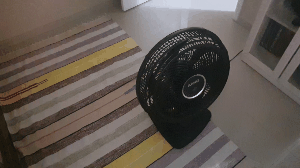

In [ ]:
# Plays the gif associated with the video
play_gif(instance_data['media']['gif'])

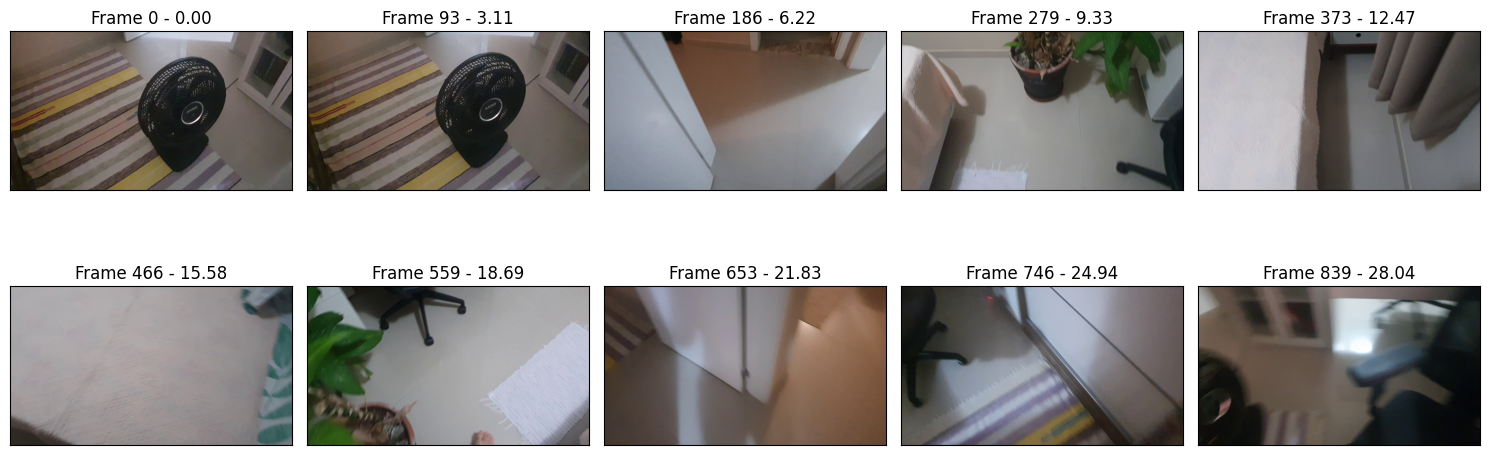

In [ ]:
# Plots a few frames related with the video
plot_video_frames(instance_data['media']['video'])

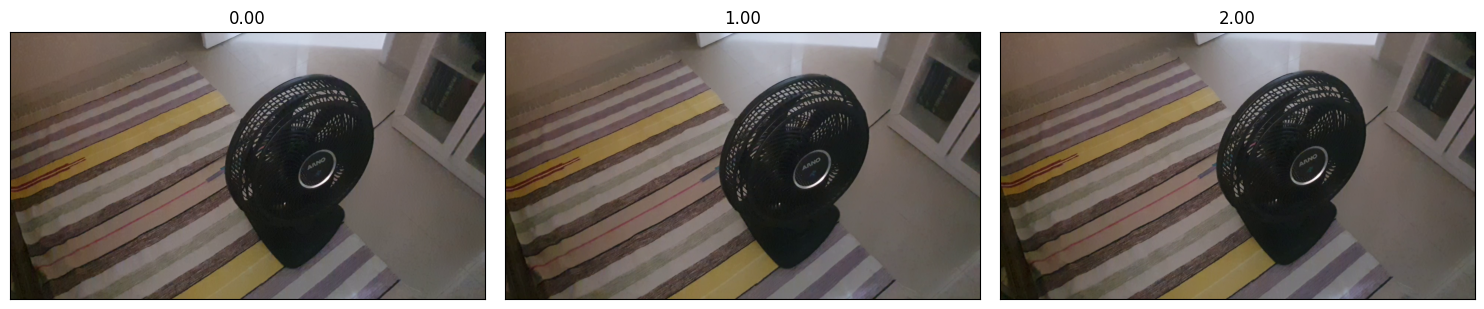

In [ ]:
# Plots a few frames related with the video
plot_video_frames_at_times(instance_data['media']['video'], [0, 1, 2])

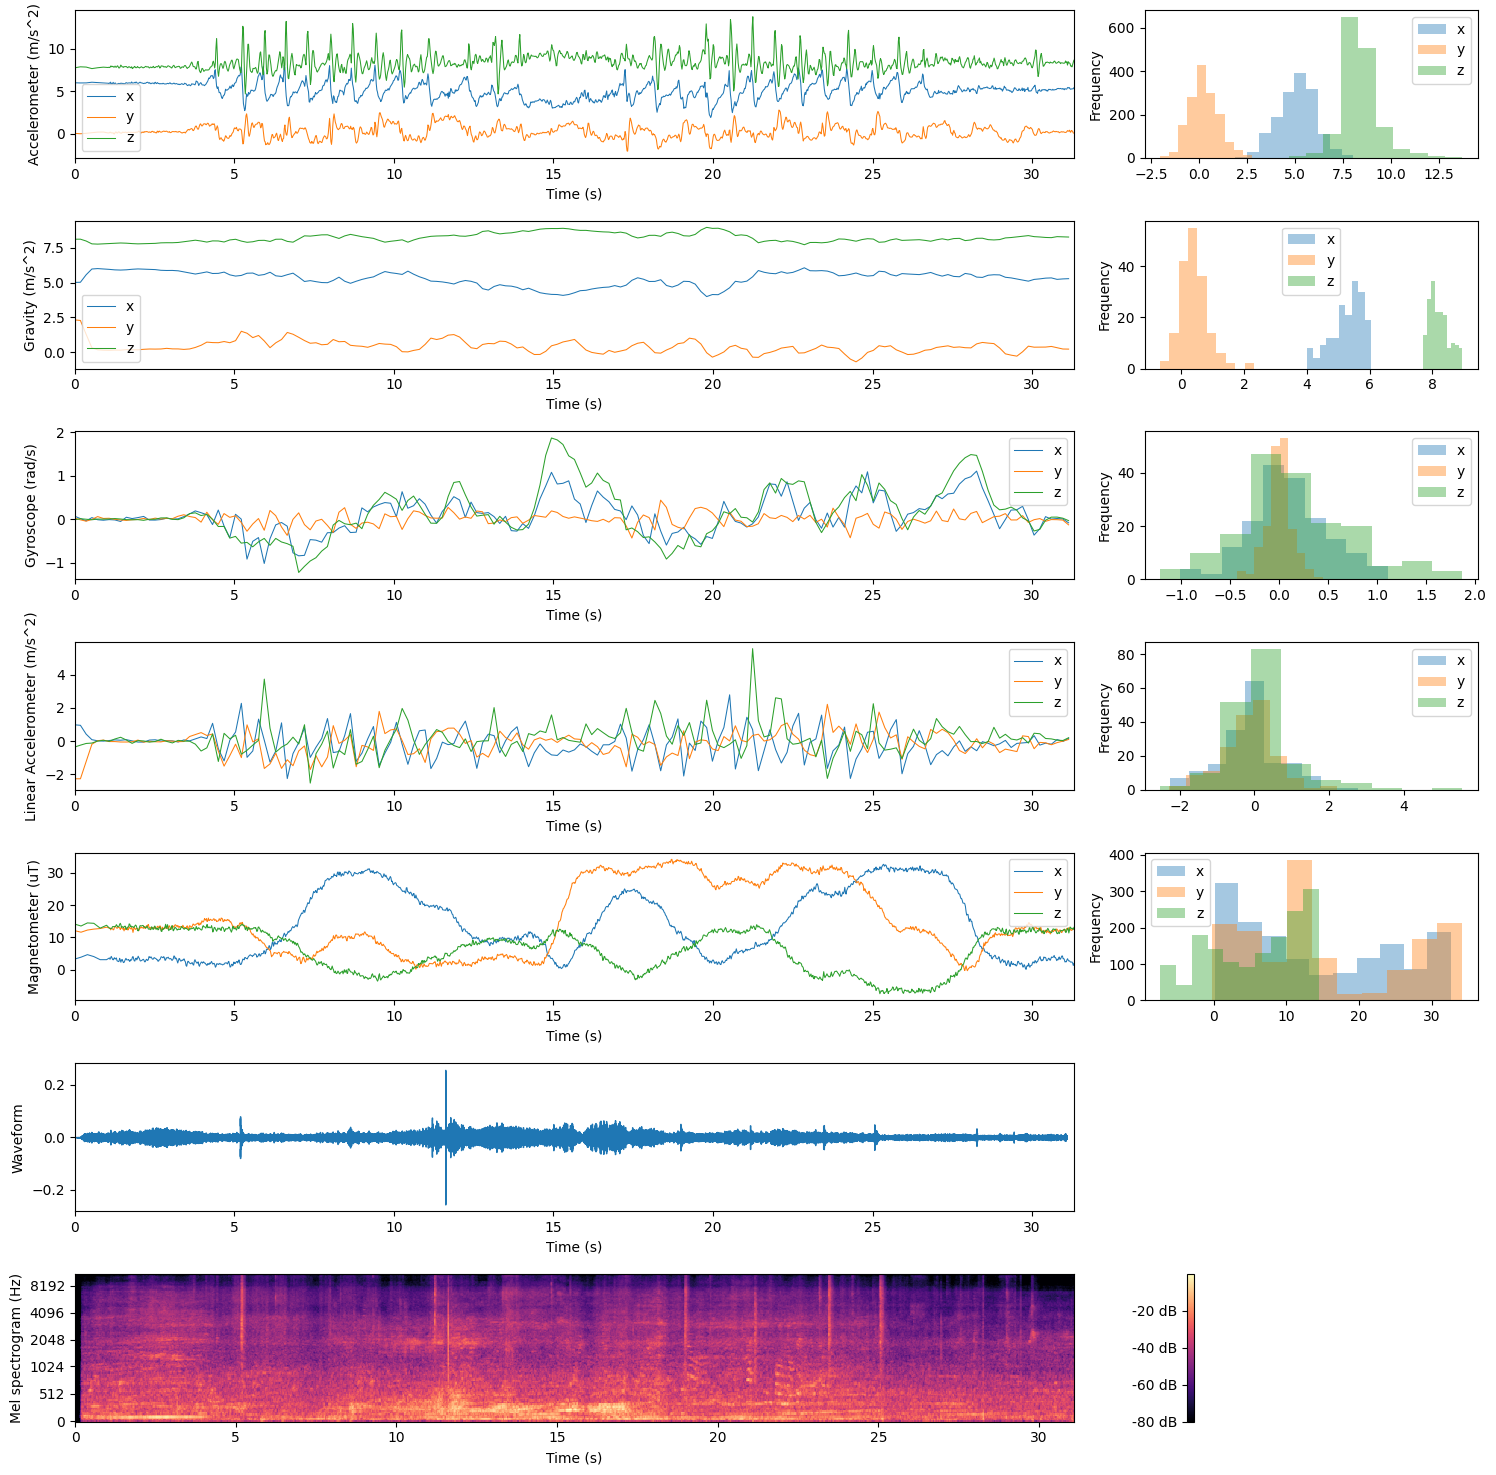

In [ ]:
# Plots the time series and histograms of all sensors and the waveform and Mel spectogram of the audio data.
plot_sensors_and_audio(instance_data['sensors'], instance_data['media']['audio'])

### 3.2. View multiple samples/categories at a time
The idea is to present all instances (or the selected ones) associated with a single sensor at a time in an unified view.

In [ ]:
# Lists the available sensors
instance_data = get_instance(dataset, 'SidewalkObstacles_01')
list_available_sensors(instance_data)

['Accelerometer (m/s^2)',
 'Magnetometer (uT)',
 'Gyroscope (rad/s)',
 'Linear Accelerometer (m/s^2)',
 'Gravity (m/s^2)']

In [ ]:
selected_instances = [
    'SidewalkObstacles_01',
    'SidewalkObstacles_02',
]

Extracting WAV data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/video.mp4
Extracting GIF data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/video.mp4
Generating GIF for 7 frames


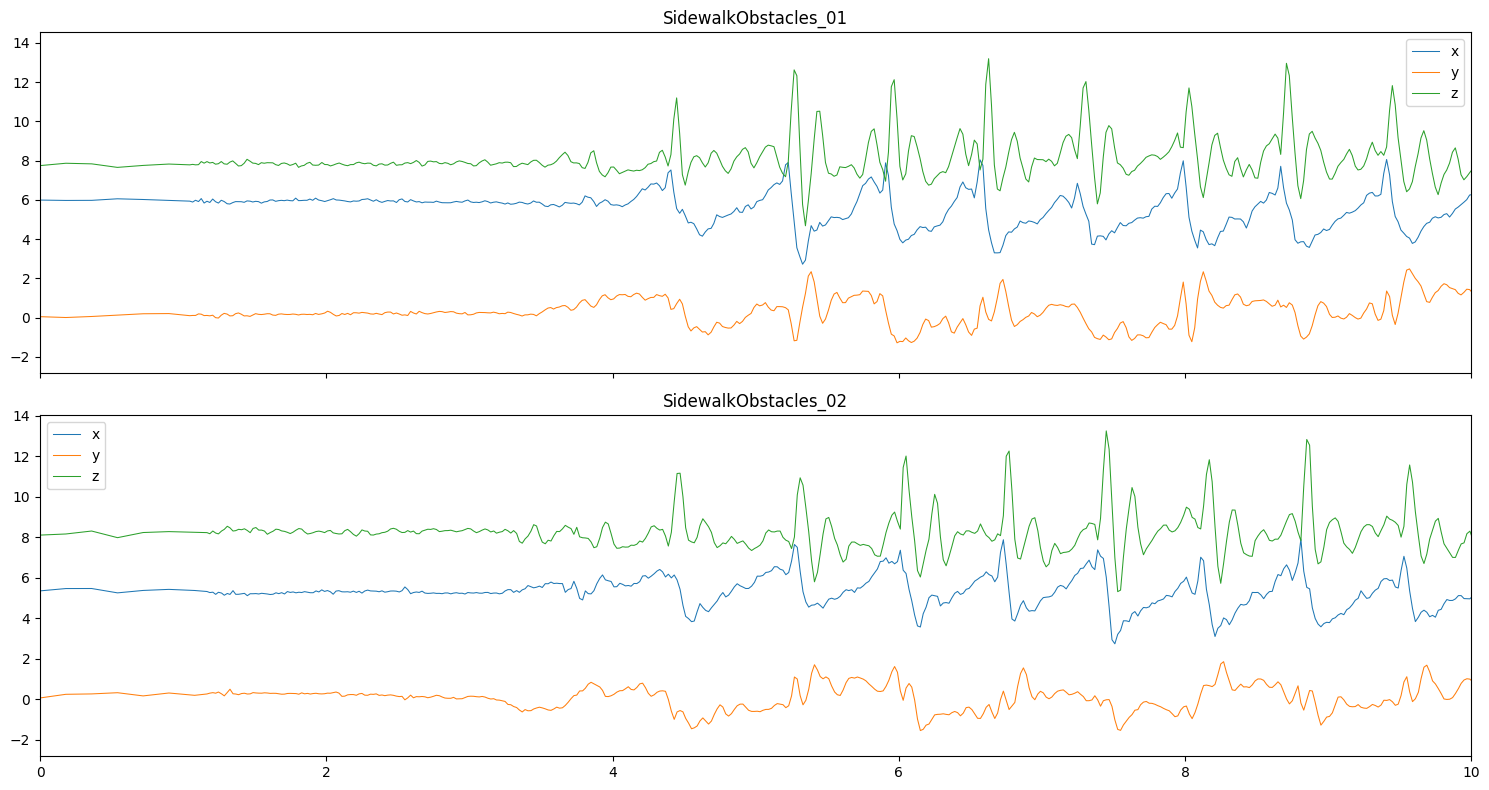

In [ ]:
plot_instances_for_sensor(
    "Accelerometer (m/s^2)",
    initial_xlim=(0, 10),
    dataset=dataset,
    identifiers=selected_instances,
)

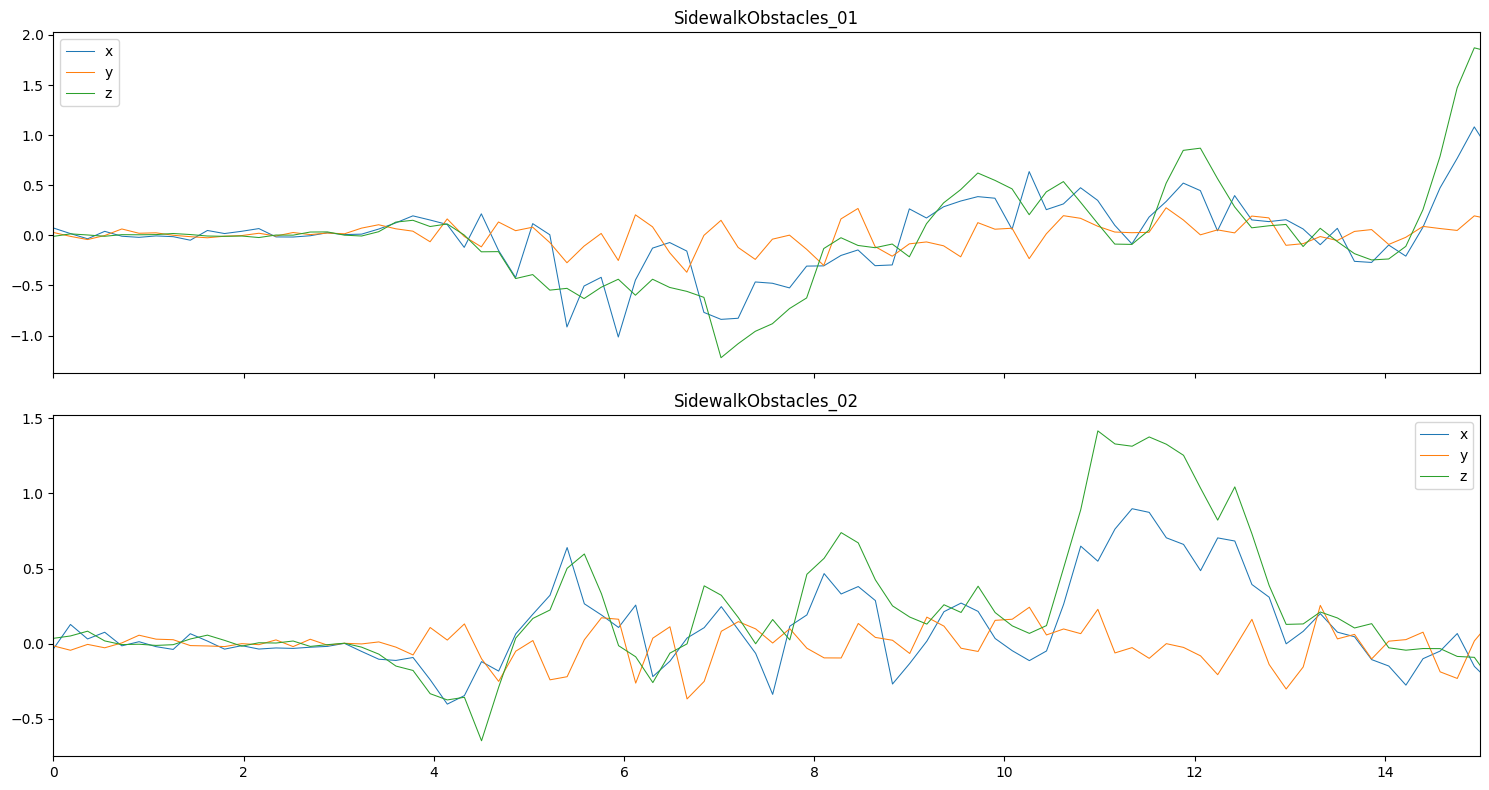

In [ ]:
plot_instances_for_sensor(
    "Gyroscope (rad/s)",
    initial_xlim=(0, 15),
    dataset=dataset,
    identifiers=selected_instances,
)

### 3.3. View multimodal data
The concept is to showcase a video alongside its corresponding time series data from the sensors.

  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



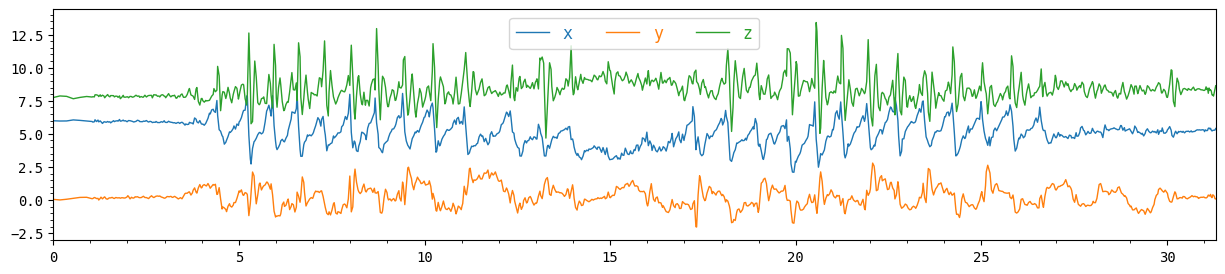

In [ ]:
# Examining how the time series will appear in the final video
plot_sensor_data(
  instance_data['sensors']['Accelerometer (m/s^2)'],
  'Accelerometer (m/s^2)'
)

In [ ]:
generate_video_path(dataset, 'SurfaceProblems_01', 'Accelerometer (m/s^2)')

Extracting WAV data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/video.mp4
Extracting GIF data from /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/video.mp4
Generating GIF for 7 frames


'/gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/accelerometer.mp4'

  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/accelerometer.mp4 for sensor Accelerometer (m/s^2)


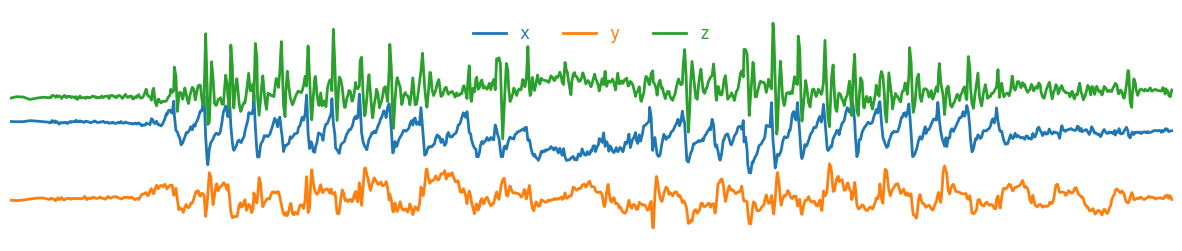

In [ ]:
# Generating video for the sensor Accelerometer
generate_video_for_sensor(
  dataset,
  'SidewalkObstacles_01',
  'Accelerometer (m/s^2)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

In [ ]:
# Generating the composite video (the original one combined with the sensor footage)
generate_video_with_sensor(
  dataset,
  'SidewalkObstacles_01',
  'Accelerometer (m/s^2)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.accelerometer.mp4 for sensor Accelerometer (m/s^2)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.accelerometer.mp4.
MoviePy - Writing audio in composite.accelerometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.accelerometer.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.accelerometer.mp4


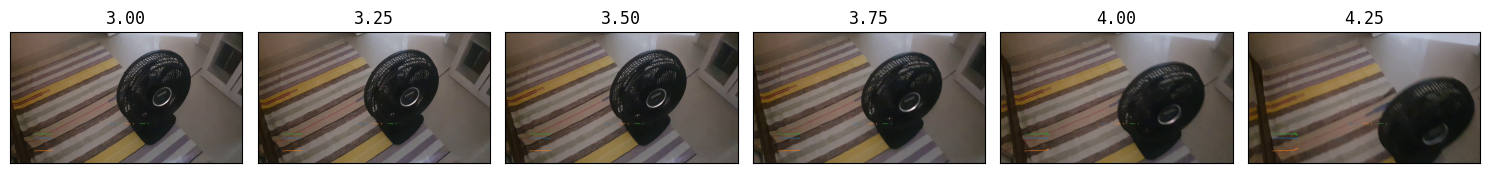

In [ ]:
# Plotting a few frames related to an interesting action that happened in the video
composite_video_path = generate_video_path(dataset, 'SidewalkObstacles_01', 'composite.accelerometer')

plot_video_frames_at_times(composite_video_path, [t for t in np.arange(3, 4.5, 0.25)])

### 3.4. Batch generation of composite videos

In [ ]:
selected_instances = [
	'SidewalkObstacles_01',
	'SidewalkObstacles_02',
	'SurfaceProblems_01',
	'SurfaceProblems_01',
] # or dataset.keys()

list_available_sensors(get_instance(dataset, 'SidewalkObstacles_01'))

['Accelerometer (m/s^2)',
 'Magnetometer (uT)',
 'Gyroscope (rad/s)',
 'Linear Accelerometer (m/s^2)',
 'Gravity (m/s^2)']

  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/accelerometer.mp4 for sensor Accelerometer (m/s^2)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.accelerometer.mp4 for sensor Accelerometer (m/s^2)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.accelerometer.mp4.
MoviePy - Writing audio in composite.accelerometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.accelerometer.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.accelerometer.mp4


  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/accelerometer.mp4 for sensor Accelerometer (m/s^2)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.accelerometer.mp4 for sensor Accelerometer (m/s^2)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.accelerometer.mp4.
MoviePy - Writing audio in composite.accelerometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.accelerometer.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.accelerometer.mp4


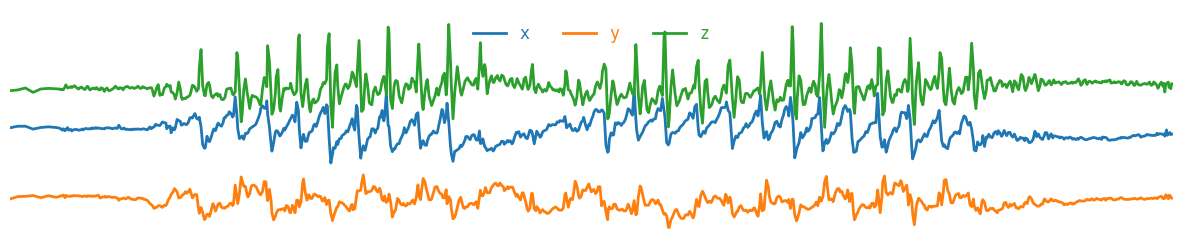

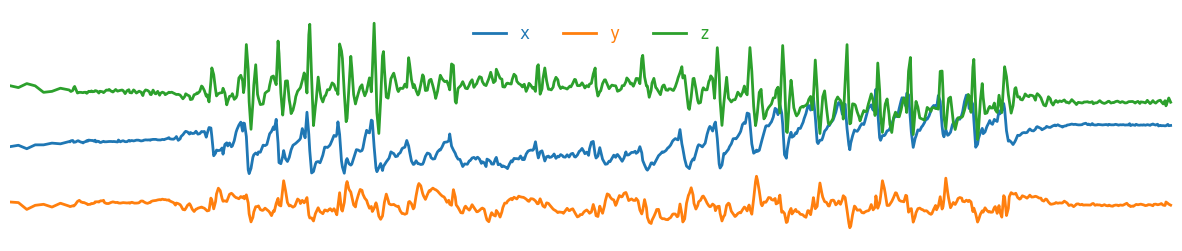

In [ ]:
for instance_id in selected_instances:
  generate_video_with_sensor(
    dataset,
    instance_id,
    sensor_name='Accelerometer (m/s^2)',
    use_dynamic_xaxis=False,
    overwrite_existant_video=False
  )

  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/gyroscope.mp4 for sensor Gyroscope (rad/s)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.gyroscope.mp4 for sensor Gyroscope (rad/s)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.gyroscope.mp4.
MoviePy - Writing audio in composite.gyroscopeTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.gyroscope.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.gyroscope.mp4


  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/gyroscope.mp4 for sensor Gyroscope (rad/s)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.gyroscope.mp4 for sensor Gyroscope (rad/s)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.gyroscope.mp4.
MoviePy - Writing audio in composite.gyroscopeTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.gyroscope.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.gyroscope.mp4


  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/gyroscope.mp4 for sensor Gyroscope (rad/s)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.gyroscope.mp4 for sensor Gyroscope (rad/s)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.gyroscope.mp4.
MoviePy - Writing audio in composite.gyroscopeTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.gyroscope.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.gyroscope.mp4


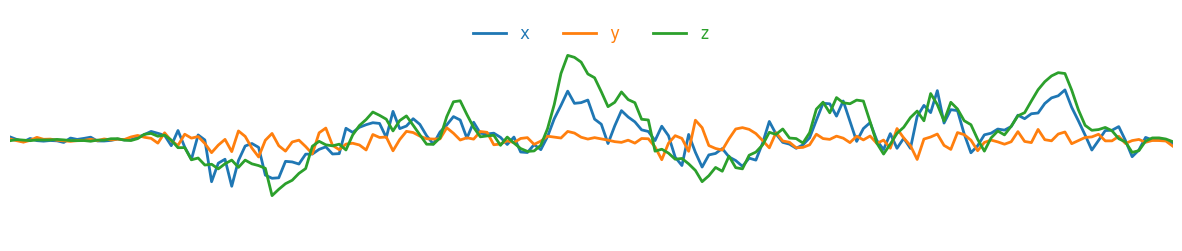

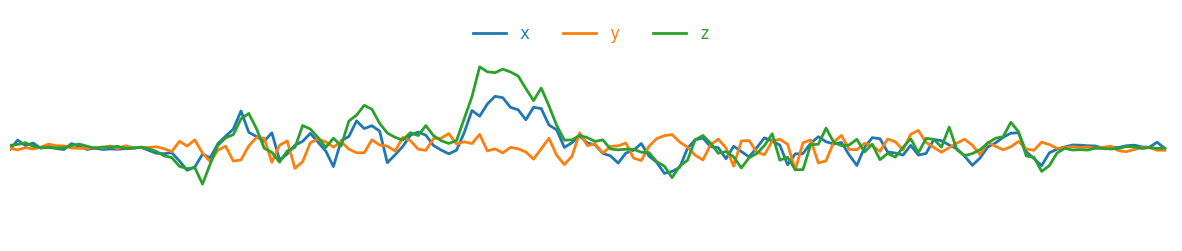

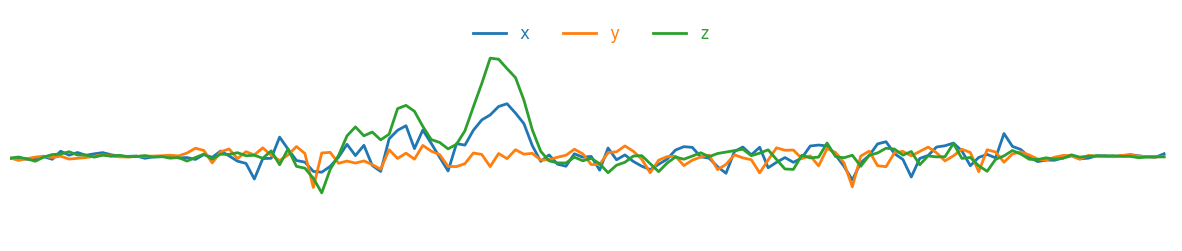

In [ ]:
for instance_id in selected_instances:
  generate_video_with_sensor(
  dataset,
  instance_id,
  'Gyroscope (rad/s)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/magnetometer.mp4 for sensor Magnetometer (uT)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.magnetometer.mp4 for sensor Magnetometer (uT)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.magnetometer.mp4.
MoviePy - Writing audio in composite.magnetometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.magnetometer.mp4



  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/01/viz/composite.magnetometer.mp4
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/magnetometer.mp4 for sensor Magnetometer (uT)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.magnetometer.mp4 for sensor Magnetometer (uT)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.magnetometer.mp4.
MoviePy - Writing audio in composite.magnetometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.magnetometer.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SidewalkObstacles/02/viz/composite.magnetometer.mp4


  return reduction(axis=axis, out=out, **passkwargs)

  return reduction(axis=axis, out=out, **passkwargs)



Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/magnetometer.mp4 for sensor Magnetometer (uT)
Generating video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.magnetometer.mp4 for sensor Magnetometer (uT)
Moviepy - Building video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.magnetometer.mp4.
MoviePy - Writing audio in composite.magnetometerTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.magnetometer.mp4



Moviepy - Done !
Moviepy - video ready /gdrive/MyDrive/science/creativision/projects/uic - vision and sensors/data/v4/SurfaceProblems/01/viz/composite.magnetometer.mp4


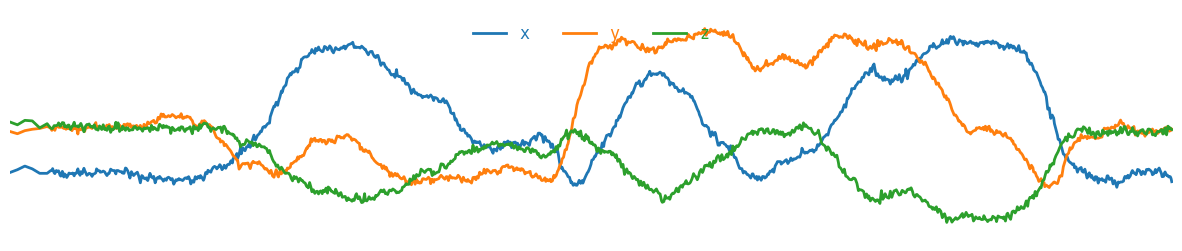

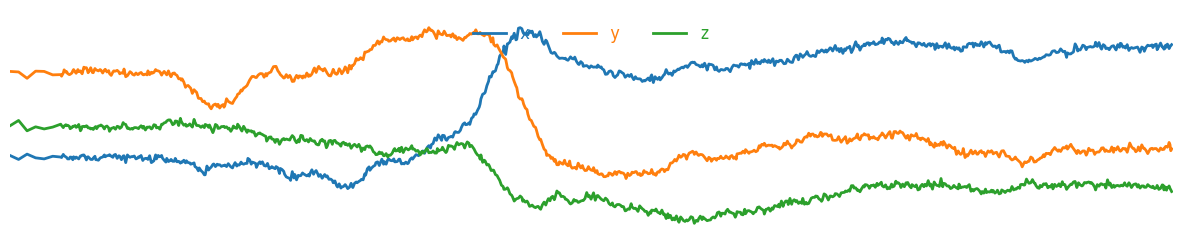

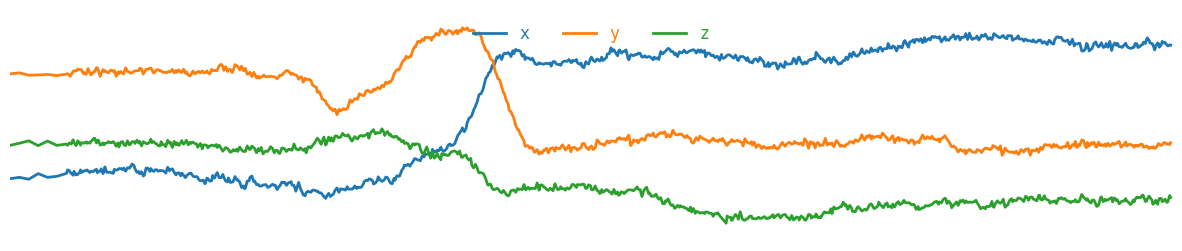

In [ ]:
for instance_id in selected_instances:
  generate_video_with_sensor(
  dataset,
  instance_id,
  'Magnetometer (uT)',
  use_dynamic_xaxis=False,
  overwrite_existant_video=False
)

## 4. Methods for tagging multimodal data
In this section, we will introduce a few implementations for tagging a sample with respect to its video, audio and sensors data.

In [ ]:
# ToDo

## 5. Methods for splitting videos
In this section, we will introduce ideas and preliminary tests related to methods for spliting video content based on sensor information. The objective is to utilize changes in the accelerometer, gyroscope, magnetometer and other sensor data to comprehensively divide a video into meaningful segments.

In [ ]:
# ToDo

## 6. Methods for video stabilization
This section aims to develop and test methods to enhance the stability of videos recorded on mobile devices. One of the issues identified in the data collected through the MultiSensor Data Collection application was the lack of image stability over time, likely attributable to the natural movement of the device while the participant walked, ran, or engaged in other activities. The methods we will test involve leveraging sensors data to correct image stability.

In [ ]:
# ToDo

# Semantic segmentation
Our goal is to create demonstration videos where the content is segmented into as many classes as possible. To achieve this, we plan to utilize segmentation models such as TMANet, finetuning them with a custom dataset if necessary. Our taxonomy could serve as a foundation for finetuning a model that is pre-trained on datasets like CityScapes. Here is the CityScapes available classes:

| Group         | Classes                                       |
|---------------|-----------------------------------------------|
| flat          | road · sidewalk · parking+ · rail track+      |
| human         | person* · rider*                              |
| vehicle       | car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+ |
| construction  | building · wall · fence · guard rail+ · bridge+ · tunnel+ |
| object        | pole · pole group+ · traffic sign · traffic light |
| nature        | vegetation · terrain                          |
| sky           | sky                                           |
| void          | ground+ · dynamic+ · static+                  |

And here is our current taxonomy:

| Category             | Subcategory                                     |
|----------------------|-------------------------------------------------|
| Adjacent road type   | Motorway/Highway · Residential · Service · None |
| Obstacles            | Aerial vegetation · Bench · Bike rack · Black ice · Bus stop · Car barrier · Construction material · Dirt · Fence · Fire hydrant · Garage entrance · Ground light · Ground vegetation · Manhole cover · Parked vehicle · Person · Pole · Potted plant · Puddle · Rock · Transit sign · Trash can · Tree leaves · Trunck · Water channel · Water fountain |
| Pavement condition   | Broken · Corrugation · Cracked · Detached · Patching · Pothole |
| Sidewalk geometry    | Height difference · Narrow · Steep |
| Sidewalk structure    | Bioswale · Curb ramp · Footbridge · Friction strip · Ramp · Stairs · Tactile paving |
| Surface type         | Asphalt · Brick · Coating · Concrete · Concrete with aggregates · Grass · Gravel · Large pavers · Red brick · Slab · Stone pavement · Tiles |
